# Exploration: optimization of a surface for flux!

In [1]:
import sys, os

# sys.path.insert(0, os.path.abspath('../../'))
from motors.simulation import *
from motors.plot import *
prepare_plot()

import matplotlib as mpl
import scipy as sc
from scipy import interpolate

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

Let's start with a fixed bound surface and optimize a second surface for flux. The bound surface is a sawtooth wave that has been smoothed by seven spline points.

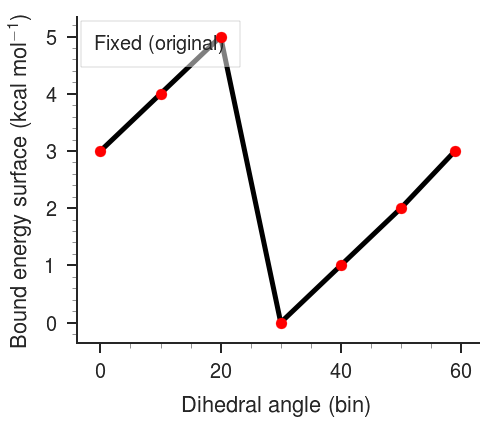

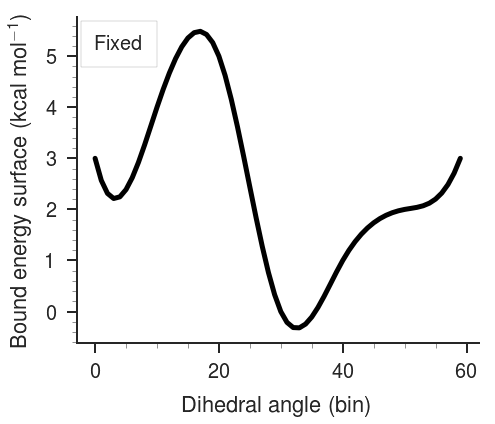

In [35]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3],
         color='k')
ax1.scatter([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3],
         color='r', s=120, zorder=10)
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText('Fixed (original)', prop=dict(size=20), frameon=True, loc=2)
at.patch.set(boxstyle='square', alpha=0.5)
ax1.add_artist(at)
paper_plot(fig, save=True, filename='bound-presmoothing-surface')

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot(range(60), 
         interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], 
         xnew=np.arange(60)),
         color='k')
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText('Fixed', prop=dict(size=20), frameon=True, loc=2)
at.patch.set(boxstyle='square', alpha=0.5)
ax1.add_artist(at)
paper_plot(fig, save=True, filename='fixed-bound-surfaces')

In [3]:
def objective(spline_points):
    x_points = [0, 10, 20, 30, 40, 50, 59]

    xnew = np.arange(60)
    energy = interpolate.spline(x_points, spline_points, xnew=xnew)
    energies.append(energy)
    
    this = Simulation(data_source = 'manual')
    this.unbound = energy
    this.bound = interpolate.spline(x_points, [3, 4, 5, 0, 1, 2, 3], xnew=xnew)

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3  # molar

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

In [4]:
guess = [0, 0, 0, 0, 0, 0, 0]
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective, guess, method='Nelder-Mead')

Curiously, the number of iterations is not consistent as I run and re-run this optimization. I'm not sure what is going on because the algorithm should be deterministic given the same random seed. The number of function evalutions seem to vary from 1200 to 1400.

In [5]:
iterations = []
for iteration in range(100):
    guess = [0, 0, 0, 0, 0, 0, 0]
    np.random.seed(42)
    results = sc.optimize.minimize(objective, guess, method='Nelder-Mead')
    iterations.append(results['nfev'])

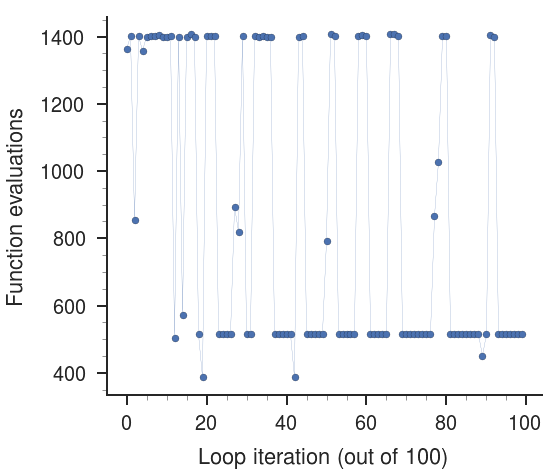

In [7]:
from motors.aesthetics import setup_plot
fig, ax = setup_plot('Function evaluations', 'Loop iteration (out of 100)')
ax.scatter(range(100), iterations, lw=0.2, edgecolor='k')
ax.plot(range(100), iterations, lw=0.2)
paper_plot(fig, save=True, filename='nelder-mead-evaluations')

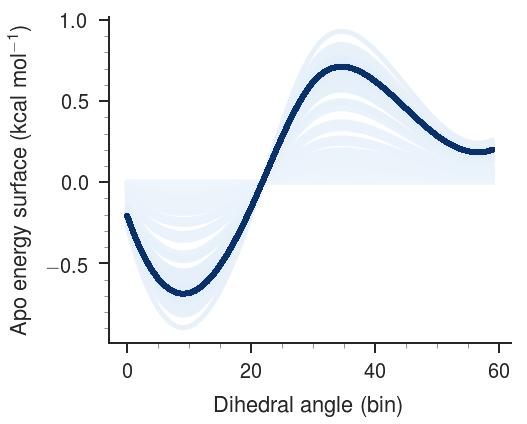

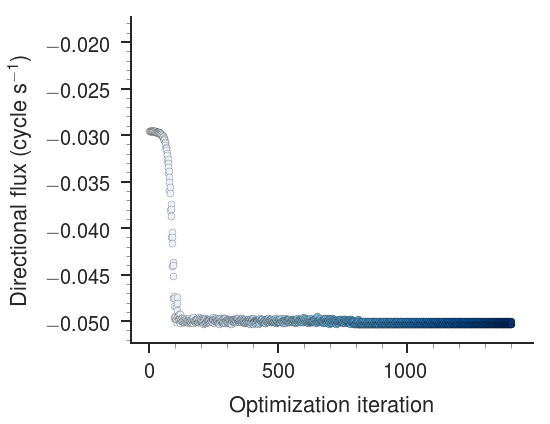

In [29]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,energy in enumerate(energies):
    ax1.plot(range(60), energy, color=c[index])
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
paper_plot(fig, save=True, filename='optimized-apo-surfaces')


fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,flux in enumerate(fluxes):
    ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Directional flux (cycle s$^{-1}$)')
paper_plot(fig, save=True, filename='flux-iterations')

The flux goes from near zero to -0.050 cycles per second.

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


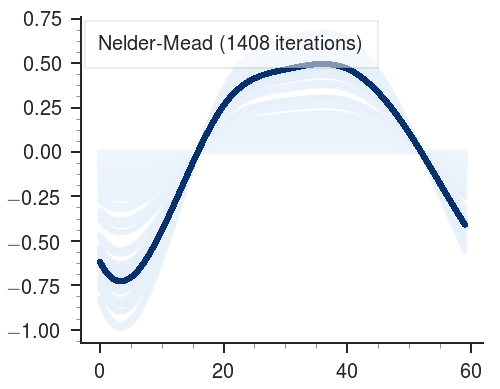

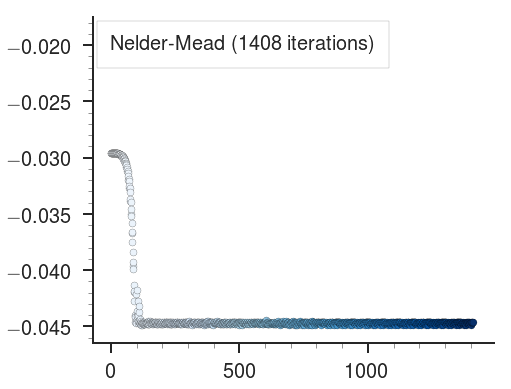

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


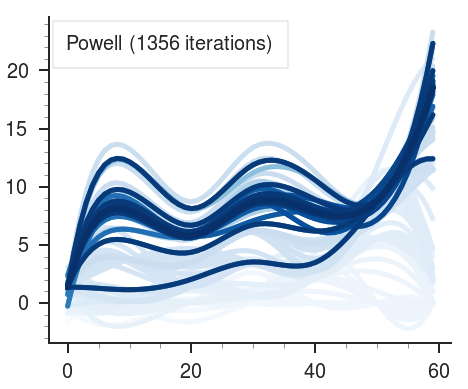

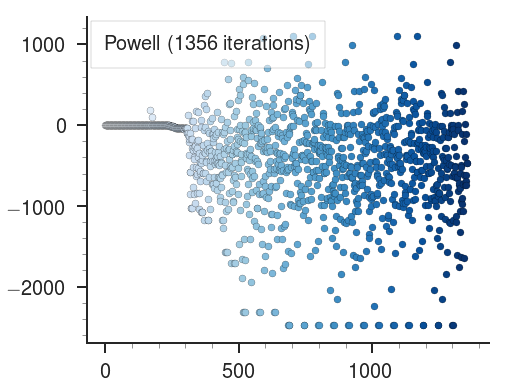

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


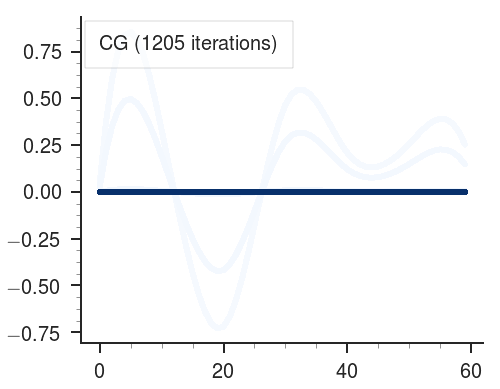

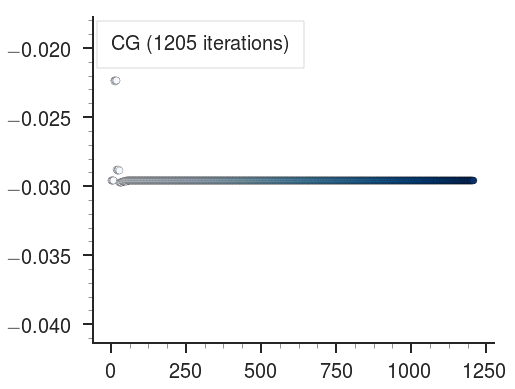

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


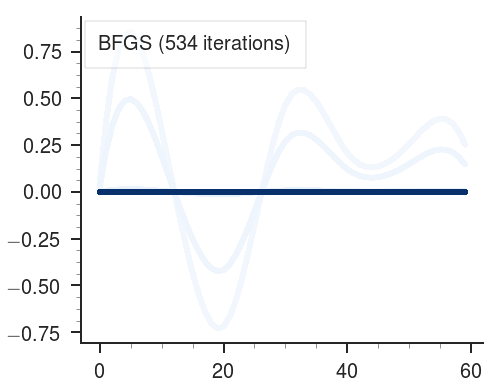

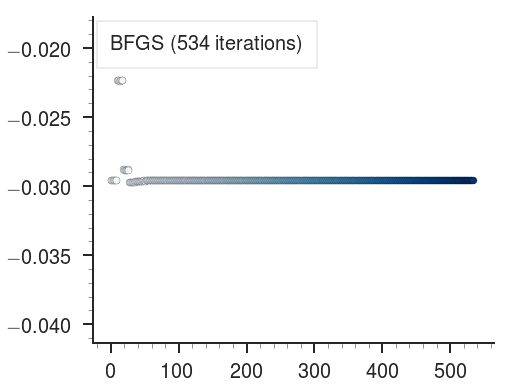

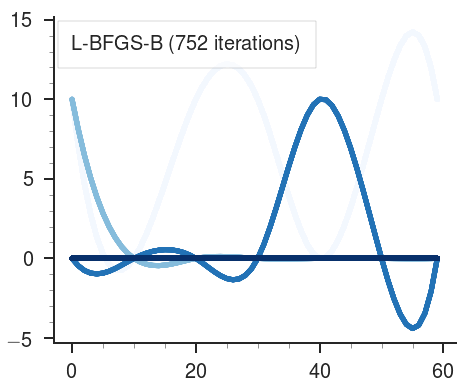

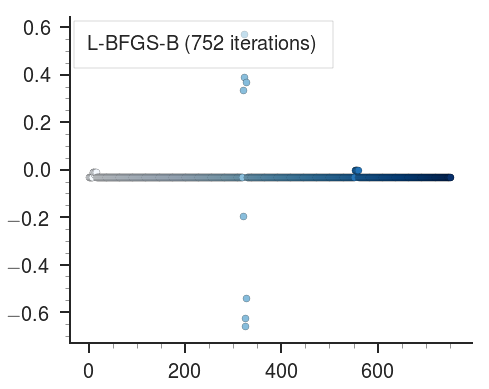

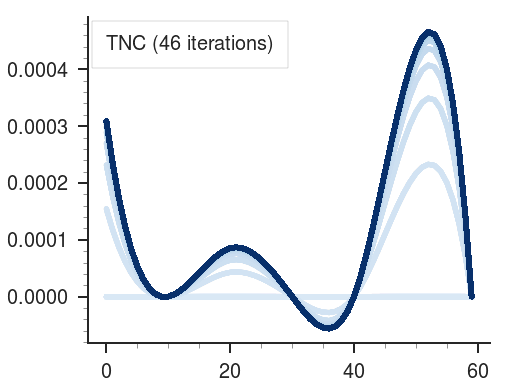

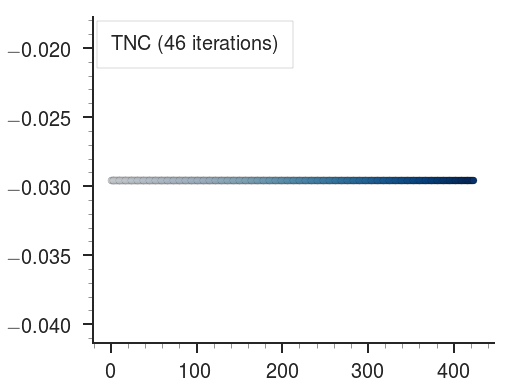

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


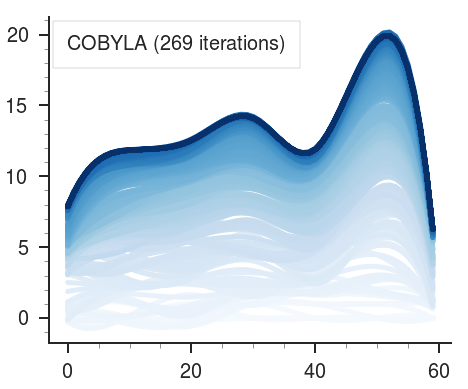

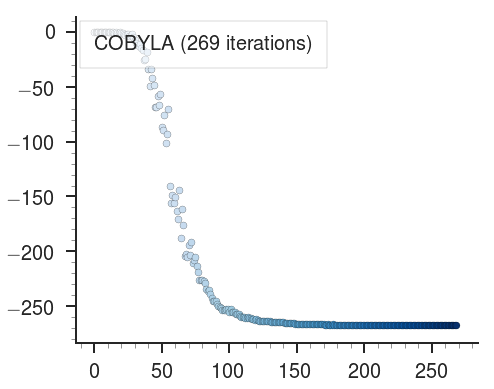

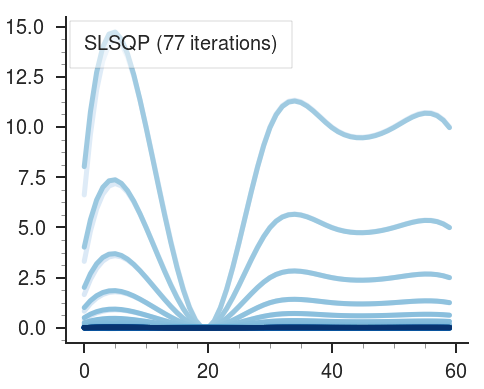

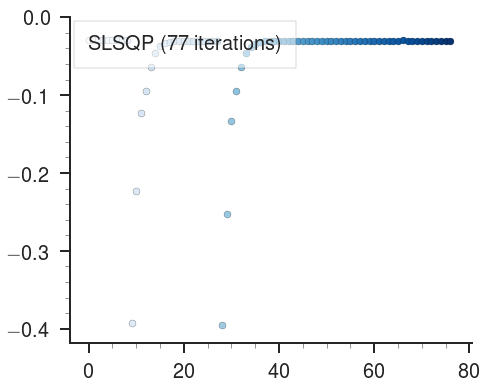

In [36]:
def plot_results(energies, fluxes, method, iterations):
    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax1 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(energies))
    for index,energy in enumerate(energies):
        ax1.plot(range(60), energy, color=c[index])
    #ax1.plot(range(60), energies[0], color='k', alpha=0, label='{} ({} iterations)'.format(method, iterations))
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    # ax1.set_xlabel('Dihedral angle (bin)')
    # ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
    paper_plot(fig)
    plt.show()

    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax2 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(energies))
    for index,flux in enumerate(fluxes):
        ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax2.add_artist(at)
    # ax2.set_xlabel('Optimization iteration')
    # ax2.set_ylabel('Directional flux (cycle s$^{-1}$)')
    paper_plot(fig)
    plt.show()
    
methods = ['Nelder-Mead',
          'Powell',
          'CG',
          'BFGS',
          'L-BFGS-B',
          'TNC',
          'COBYLA',
          'SLSQP']
for method in methods:
    guess = [0, 0, 0, 0, 0, 0, 0]
    energies = []
    fluxes = []
    # np.random.seed(42)
    results = sc.optimize.minimize(objective, guess, method=method,
                         bounds=((0, 10), (0, 10), (0, 10),
                                 (0, 10), (0, 10), (0, 10),
                                 (0, 10)))
    plot_results(energies, fluxes, method, results['nfev'])

## Optimize both surfaces together

In [126]:
def objective(spline_points):
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
    
    apo   = interpolate.spline(spline_x, spline_points[0:len(spline_x)], xnew=full_x)
    bound = interpolate.spline(spline_x, spline_points[len(spline_x):2 * len(spline_x)], xnew=full_x)
    
     
    
    apos.append(apo)
    bounds.append(bound)
    
    this = Simulation(data_source = 'manual')
    this.unbound = apo
    this.bound = bound

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

In [9]:
def plot_results(apos, bounds, fluxes, method, iterations):
    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax1 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,energy in enumerate(apos):
        ax1.plot(range(60), energy, color=c[index])
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    paper_plot(fig)
    plt.show()
    
    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax1 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,energy in enumerate(bounds):
        ax1.plot(range(60), energy, color=c[index])
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    paper_plot(fig)
    plt.show()

    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax2 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,flux in enumerate(fluxes):
        ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    at = AnchoredText('{0} ({1:4.2f} cycle s$^ {{-1}}$)'.format(method, fluxes[-1]),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax2.add_artist(at)
    paper_plot(fig)
    plt.show()

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


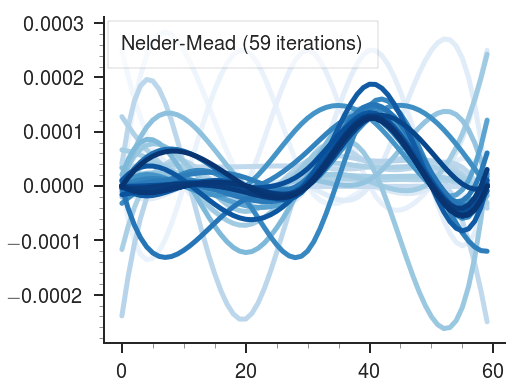

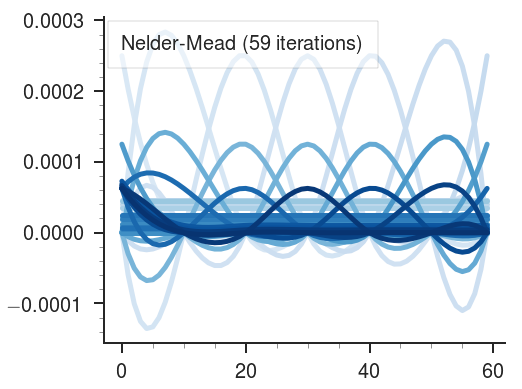

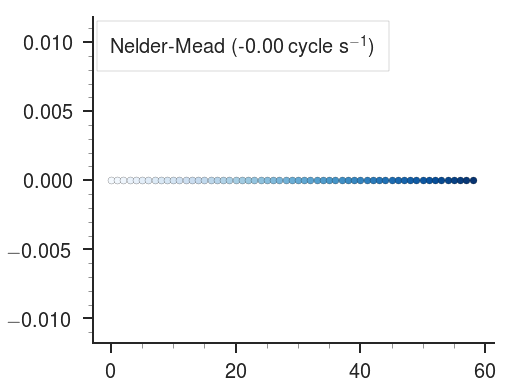

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
/media/dslochower/data-beta/projects/nonequilibrium-manuscript/simulation.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


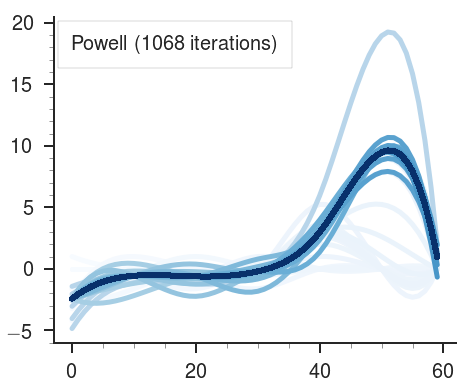

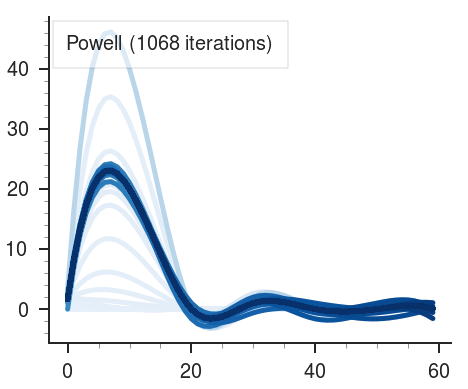

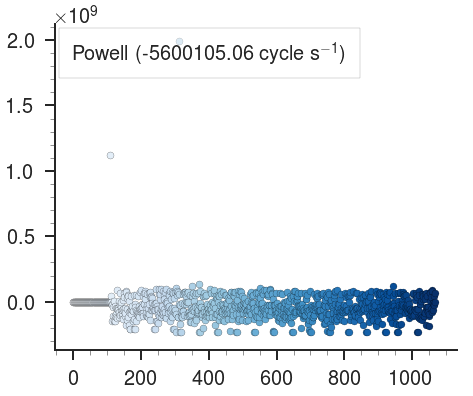

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


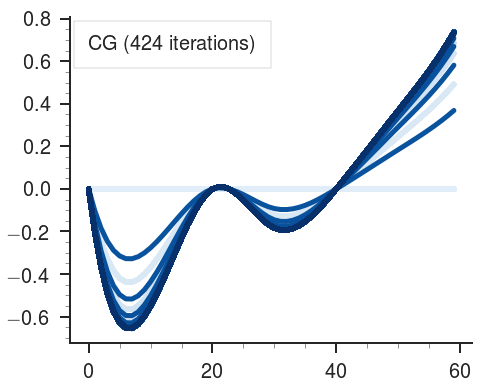

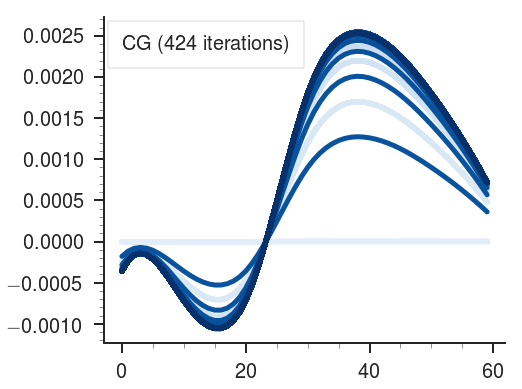

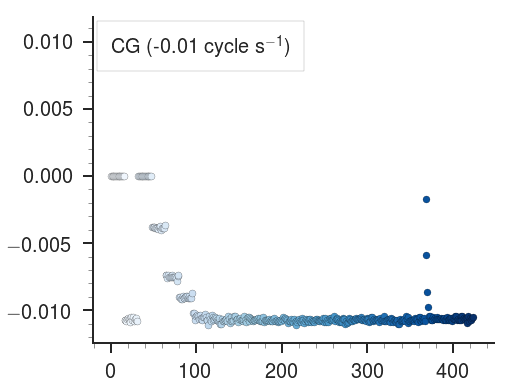

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


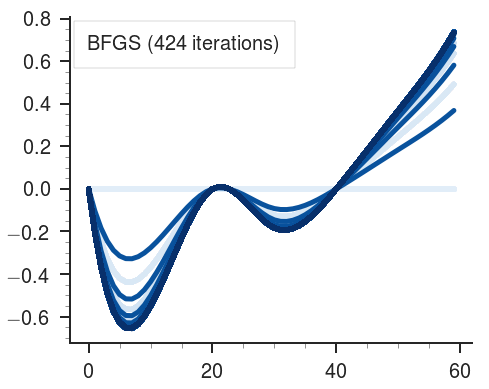

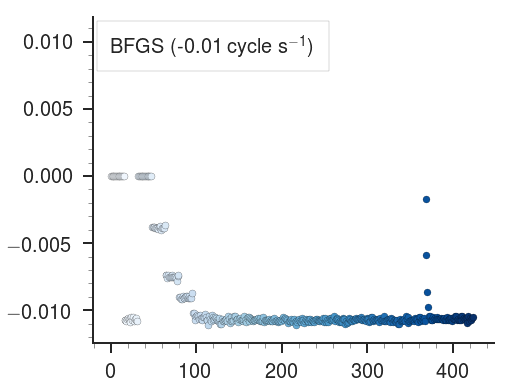

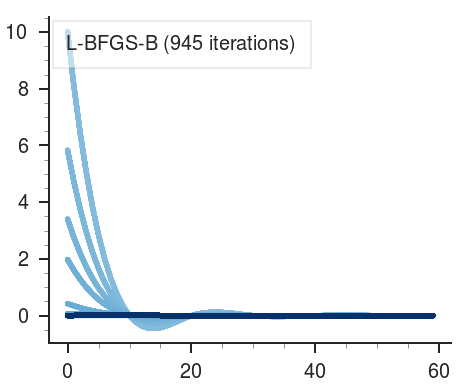

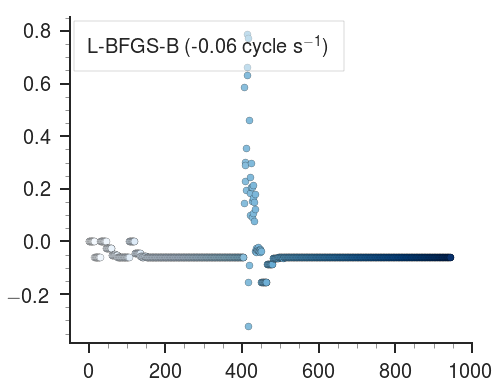

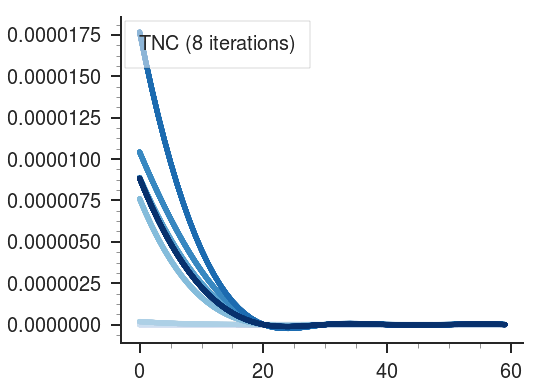

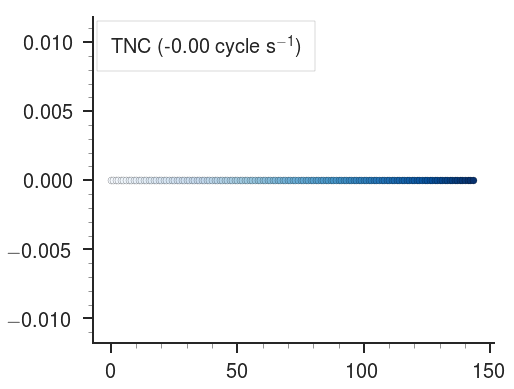

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


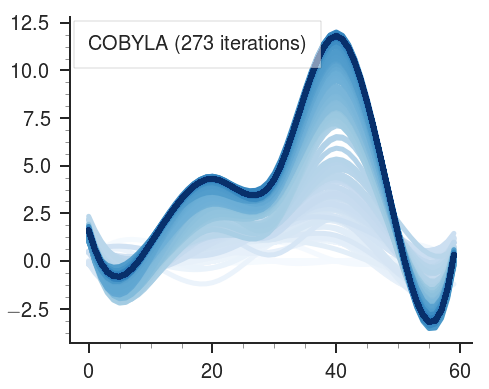

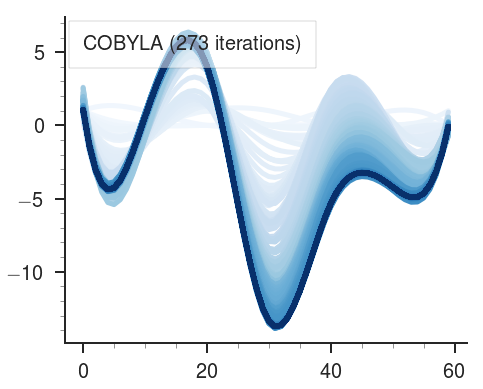

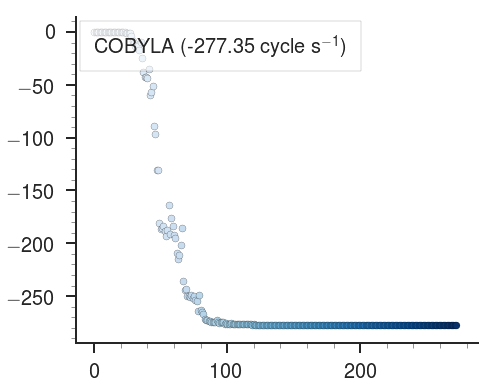

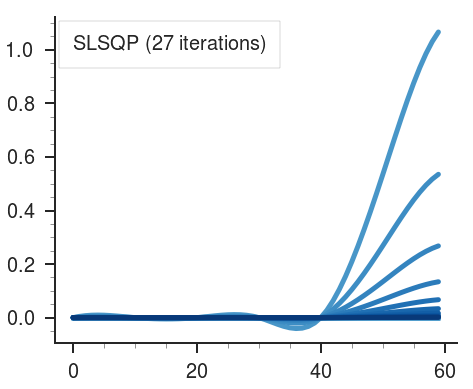

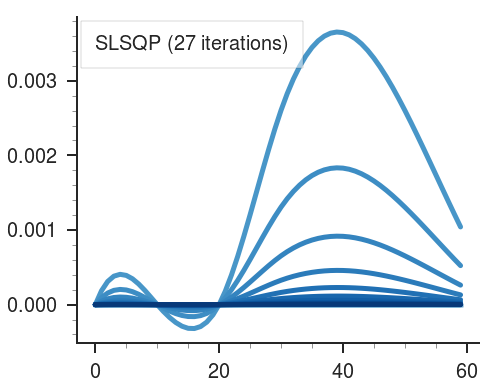

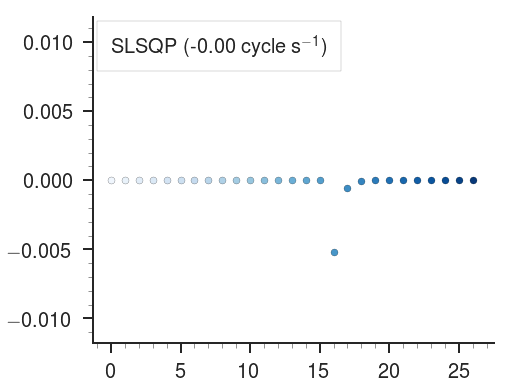

In [142]:
methods = ['Nelder-Mead',
          'Powell',
          'CG',
          'BFGS',
          'L-BFGS-B',
          'TNC',
          'COBYLA',
          'SLSQP']
for method in methods:
    guess = [0, 0, 0, 0, 0, 0, 0]*2
    apos = []
    bounds = []
    fluxes = []
    # np.random.seed(42)
    results = sc.optimize.minimize(objective, guess, method=method,
                         bounds=((0, 10), (0, 10), (0, 10),
                                 (0, 10), (0, 10), (0, 10),
                                 (0, 10), (0, 10), (0, 10),
                                 (0, 10), (0, 10), (0, 10),
                                 (0, 10), (0, 10)))
    plot_results(apos, bounds, fluxes, method, results['nfev'])

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


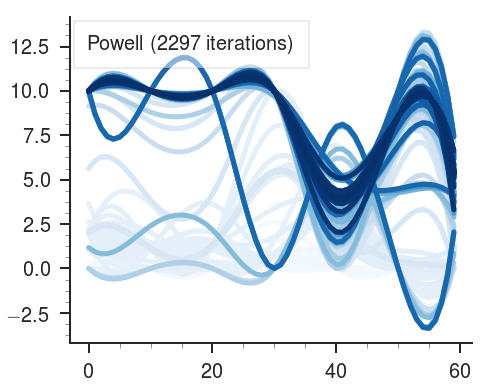

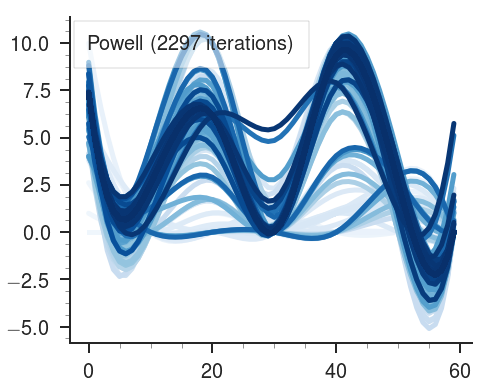

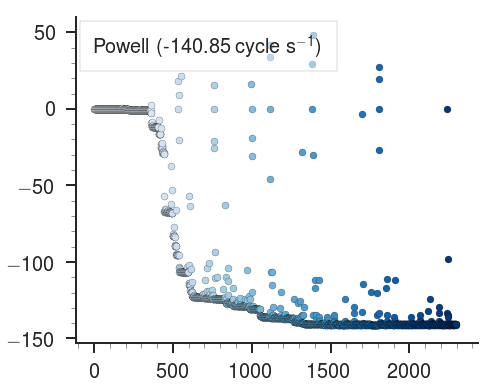

In [195]:
def objective_pinned(spline_points):
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
        
    for index, point in enumerate(spline_points):
        if point >= 10:
            spline_points[index] = 10
        if point <= 0:
            spline_points[index] = 0
    
    apo   = interpolate.spline(spline_x, spline_points[0:len(spline_x)], xnew=full_x)
    bound = interpolate.spline(spline_x, spline_points[len(spline_x):2 * len(spline_x)], xnew=full_x)
    
    apos.append(apo)
    bounds.append(bound)
    
    this = Simulation(data_source = 'manual')
    this.unbound = apo
    this.bound = bound

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

guess = [0, 0, 0, 0, 0, 0, 0]*2
apos = []
bounds = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective_pinned, guess, method='Powell',
                     bounds=((0, 0.1), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10)))


plot_results(apos, bounds, fluxes, 'Powell', results['nfev'])

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


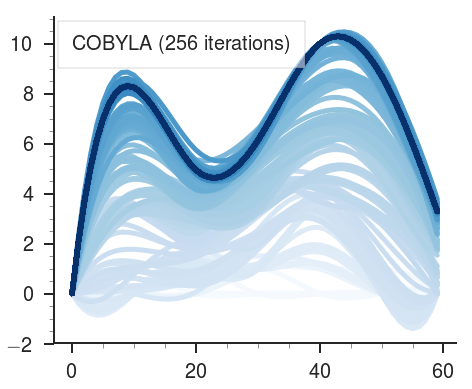

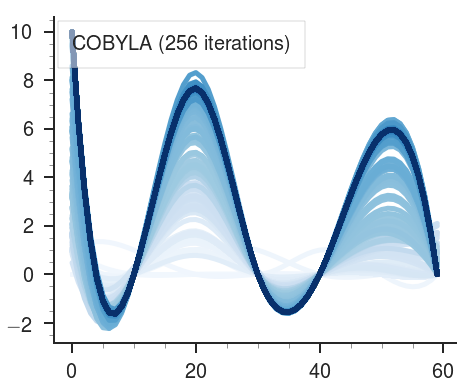

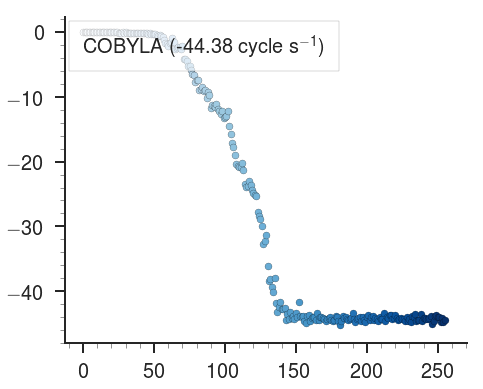

In [13]:
def objective_pinned(spline_points):
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
        
    for index, point in enumerate(spline_points):
        if point >= 10:
            spline_points[index] = 10
        if point <= 0:
            spline_points[index] = 0
    
    apo   = interpolate.spline(spline_x, spline_points[0:len(spline_x)], xnew=full_x)
    bound = interpolate.spline(spline_x, spline_points[len(spline_x):2 * len(spline_x)], xnew=full_x)
    
    apos.append(apo)
    bounds.append(bound)
    
    this = Simulation(data_source = 'manual')
    this.unbound = apo
    this.bound = bound

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

guess = [0, 0, 0, 0, 0, 0, 0]*2
apos = []
bounds = []
fluxes = []
# np.random.seed(42)
results = sc.optimize.minimize(objective_pinned, guess, method='COBYLA',
                     bounds=((0, 0.1), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10)))


plot_results(apos, bounds, fluxes, 'COBYLA', results['nfev'])

In [187]:
results['x']

array([ 35.57885318,  31.99026952,  32.63605038,  19.78196237,
         3.95862005,   8.55314693,   5.37203062,   7.37700607,
         2.56155739,   6.18622577,  -0.65212298,   9.35808631,
         2.59733253,  -0.37745617])

In [188]:
spline_x = [0, 10, 20, 30, 40, 50, 59]
full_x   = np.arange(60)

for index, point in enumerate(results['x']):
    if point >= 10:
        results['x'][index] = 10
    if point <= 0:
        results['x'][index] = 0

print(results['x'])
apo   = interpolate.spline(spline_x, results['x'][0:7], xnew=full_x)
bound = interpolate.spline(spline_x, results['x'][7:], xnew=full_x)

apos.append(apo)
bounds.append(bound)

this = Simulation(data_source = 'manual')
this.unbound = apo
this.bound = bound

this.C_intersurface = 10 ** 6     # per mole per second
this.offset_factor = 5.7          # kcal per mol
this.catalytic_rate = 312         # per second
this.cSubstrate = 2.5 * 10 ** -3

this.simulate(user_energies=True)

[ 10.          10.          10.          10.           3.95862005
   8.55314693   5.37203062   7.37700607   2.56155739   6.18622577   0.
   9.35808631   2.59733253   0.        ]


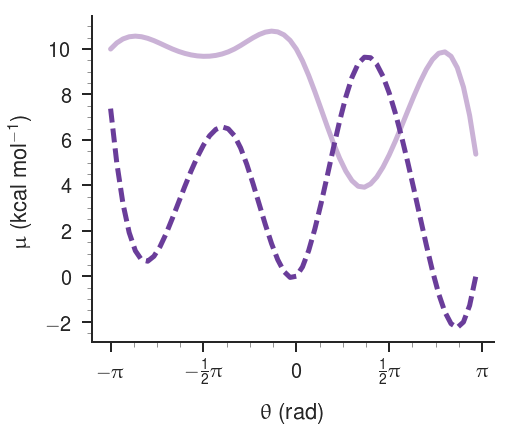

In [189]:
plot_energy(this)

C                         +1.00e+06  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.50e-03  M         
dt                        +1.00e-14  second    
-------------------------
Intrasurface flux         -1.41e+02  cycle second**-1
Peak                      +9.99e+01  cycle second**-1


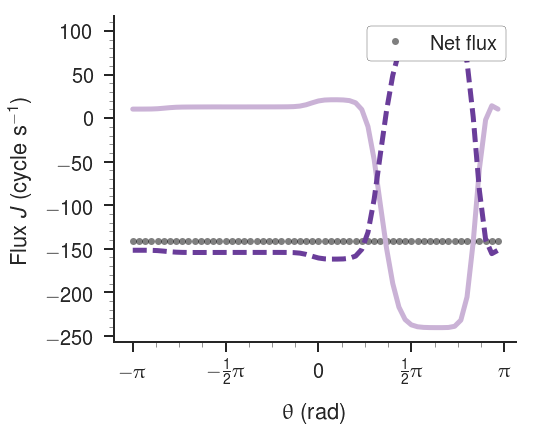

In [190]:
plot_flux(this)